In [ ]:
# general
import pandas as pd
import numpy as np
import math

# plots
import matplotlib.pyplot as plt

# sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

## Solution 1: Tuning $k$-NN

### a)

role of hyperparameters:

- `n_neighbors`: determines the size of the neighborhood and thus influences the locality of the model. Smaller neighborhoods reflect the belief that only very similar (close) neighbors should be allowed to weigh into the prediction of a new observation, and predictions may change strongly for only small changes of the input variables. If `n_neighbors` is chosen too small, we may encounter overfitting. Conversely, larger neighborhoods produce a more global model with larger parts of the input space receiving the same prediction. Setting `n_neighbors` too large may result in underfitting.

- `weights`: It determines the importance weights in the k-neighborhood. Possible values are:
    - ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
    - ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. This setting is strongly dependent on the parameter `metric`
    - [`callable`] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

- `metric`: Metric to use for distance computation. Some of the more widely applied metric include:
     - `euclidean`: distance is computed by the L2-norm
     - `manhattan`: distance is computed by the L1-norm
     - `cosine`: distance is computed by $1-\frac{u \cdot v}{\|u\|_2 \|v\|_2}$
     - `minkowski`: given the parameter p the distance is computed by $\|u - v\|_p$

Load data [credit_for_py.csv](https://github.com/slds-lmu/lecture_i2ml/blob/master/exercises/data/credit_for_py.csv) and seperate into train and test set.

In [2]:
# | label: 1-a
german_credit = pd.read_csv(
    "https://raw.githubusercontent.com/slds-lmu/lecture_i2ml/master/exercises/data/credit_for_py.csv"
)
german_X = german_credit.copy()
german_y = german_X.pop("credit_risk")

# The full data set has 690 observations --> split at test_size = 0.2 to obtain 138 observations for testing.
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(
    german_X, german_y, test_size=0.2, random_state=42
)

# For kNN you have to scale your feature space such that the standard deviation is equal over all features.
# If we wouldn't do this, the result would be heavily weighted by larger scaled features.
scaler = StandardScaler()
# Fit and normalize the data after splitting it into training and test sets.
# This is to prevent ‘data leakage’ as the normalization would give the model additional information about the test set.
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

### b)

Each instance of RandomizedSearchCV has a slot *param_distributions* containing all hyperparameters that can be set during tuning. It has to be passed as a dictionary or a list of dictionaries. Note that single values also have to be passed as a list to the dictionary. <br>
Furthermore, we need to consider valid (hyper)parameter tuples in the design of the hyperparameter space. <br>
Due to the **duck typing** behaviour of Python, we do not need to specify the type of our hyperparameters (type or the class of an object is less important than the methods it defines):

In [3]:
# | label: 1-b
# List hyperparameters that we want to consider for tuning.
n_neighbors = list(range(1, 101))
weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan", "cosine"]
# Convert to dictionary and consider valid hyperparameter tuples
hyperparameters = [
    dict(n_neighbors=n_neighbors, weights=[weights[0]]),
    dict(n_neighbors=n_neighbors, weights=[weights[1]], metric=metric),
]

### c)

We implement the HPO as follows:

In [4]:
# | label: 1-c
# Create new KNN instance
knn = KNeighborsClassifier()
# Use RandomSearch
clf = RandomizedSearchCV(
    estimator=knn,  # fit a KNeighborsClassifier
    param_distributions=hyperparameters,  # use defined parameter dictionary
    n_iter=200,  # sample 200 tuples out of 400 possible ones and iterate over these
    cv=5,  # use 5-fold CV
    n_jobs=-1,  # use all processers available to speed up computing
    random_state=123,
)  # make your results reproducable
# Fit the model, i.e., carry out tuning and in the end, fit model with best hyperparameters
best_model = clf.fit(X_train, y_train)
# Print The value of best hyperparameters
print("Best n_neighbors:", best_model.best_estimator_.get_params()["n_neighbors"])
print("Best weights:", best_model.best_estimator_.get_params()["weights"])
print("Best metric:", best_model.best_estimator_.get_params()["metric"])
print("Accuracy:", best_model.score(X_test, y_test))

Best n_neighbors: 12
Best weights: distance
Best metric: manhattan
Accuracy: 0.782608695652174


### Extra: How to use a gaussian kernel

In [5]:
# write a callable function to transform distances into weights
def gaussian_kernel(distances, sd=1):  # set some default for sd, it has to be tuned
    weights = np.exp(-(distances**2) / sd**2)
    return weights

In [6]:
# define a parameter grid for n_neighbors (1-50) and kernel width (1-10)
param_grid = {
    "n_neighbors": list(range(1, 51)),
    "weights": [
        lambda distances, sd=i: gaussian_kernel(distances, sd=sd) for i in range(1, 11)
    ],
}  # list of callable functions
# Note: Consider the late binding behaviour of Python's lambda functions

# Perform a GridSearchCV over all hyperparameter tuples
knn_extra = KNeighborsClassifier()
grid_search = GridSearchCV(knn_extra, param_grid, cv=5, n_jobs=-1)
gauss_model = grid_search.fit(X_train, y_train)

# Print The value of best Hyperparameters
print("Best n_neighbors:", grid_search.best_estimator_.get_params()["n_neighbors"])
print(
    "Best sd:",
    param_grid["weights"].index(grid_search.best_estimator_.get_params()["weights"])
    + 1,
)
print("Accuracy:", gauss_model.score(X_test, y_test))

Best n_neighbors: 46
Best sd: 9
Accuracy: 0.7898550724637681


### d)

In [7]:
# | label: 1-d
# Create new KNN instance
knn = KNeighborsClassifier()
# Use RandomSearch
clf_auc = RandomizedSearchCV(
    estimator=knn,
    param_distributions=hyperparameters,
    scoring="roc_auc",  # use the AUC metric for finding the best hyperparameter set
    n_iter=200,
    cv=5,
    n_jobs=-1,
    random_state=123,
)
# Fit the model
best_model_auc = clf_auc.fit(X_train, y_train)
# Print The value of best Hyperparameters
print("Best n_neighbors:", best_model_auc.best_estimator_.get_params()["n_neighbors"])
print("Best weights:", best_model_auc.best_estimator_.get_params()["weights"])
print("Best metric:", best_model_auc.best_estimator_.get_params()["metric"])
print("Accuracy:", best_model_auc.score(X_test, y_test))

Best n_neighbors: 37
Best weights: distance
Best metric: manhattan
Accuracy: 0.8754201680672269


### e)

In [8]:
def plot_validation(train_scores, test_scores, param, param_range):
    """
    Plot the validation curve for a given hyperparameter.

    Parameters:
    ----------
    train_scores : array-like of shape (n_param_values, n_folds)
        Training scores for each hyperparameter value and fold.
    test_scores : array-like of shape (n_param_values, n_folds)
        Test scores (e.g., cross-validation scores) for each hyperparameter value and fold.
    param : str
        Name of the hyperparameter being varied.
    param_range : array-like of shape (n_param_values,)
        Range of values for the hyperparameter.

    Returns:
    -------
    None
        The function plots the validation curve.

    """
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with KNN")
    plt.xlabel(param)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(
        param_range,
        train_scores_mean,
        label="Training score",
        color="darkorange",
        lw=lw,
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range,
        test_scores_mean,
        label="Cross-validation score",
        color="navy",
        lw=lw,
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()

Plot for scaled training data:

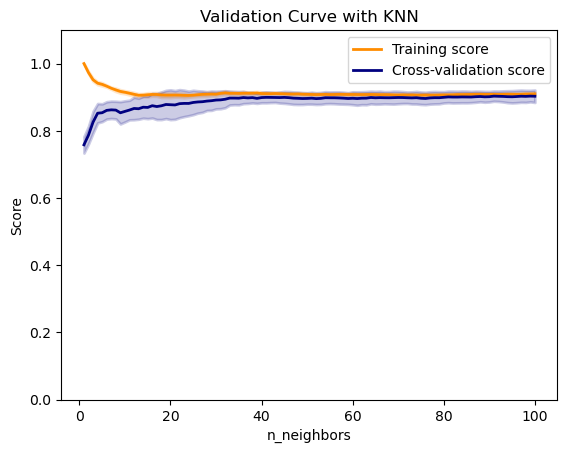

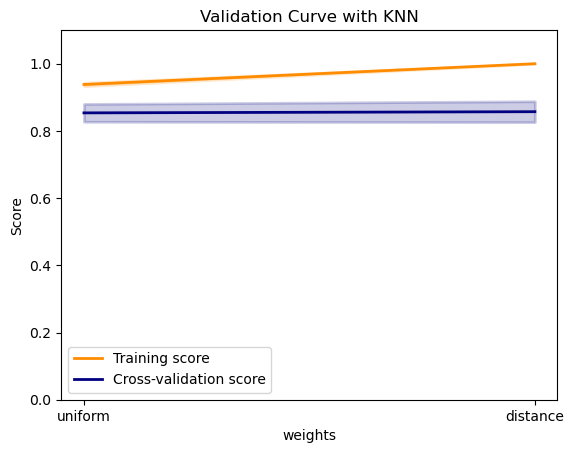

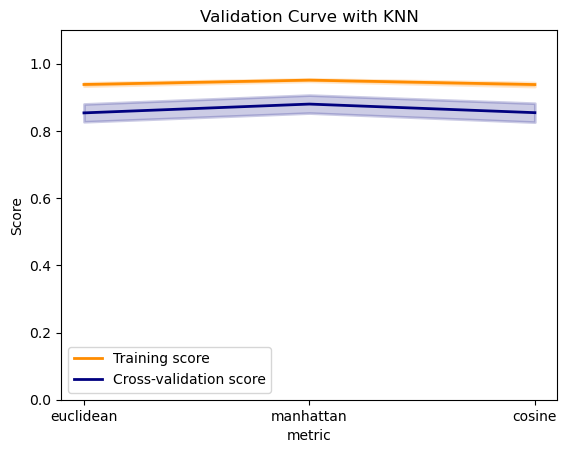

In [9]:
# | label: 1-e-1
hyper_full_set = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)
plots = hyper_full_set.keys()

for plot in plots:
    train_scores, test_scores = validation_curve(
        KNeighborsClassifier(),
        X_train,
        y_train,
        param_name=plot,
        param_range=hyper_full_set[plot],
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
    )
    plot_validation(train_scores, test_scores, plot, hyper_full_set[plot])

Plot for unscaled training data:

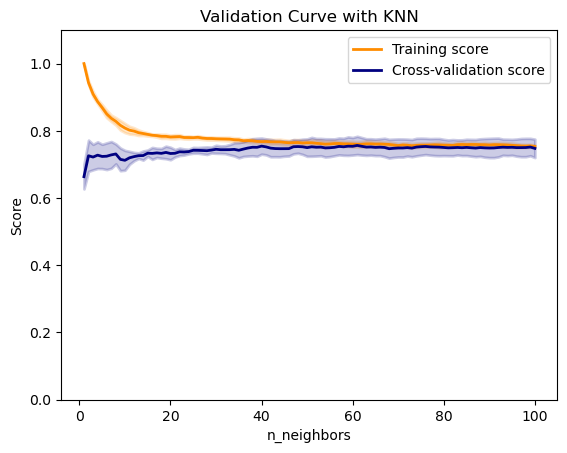

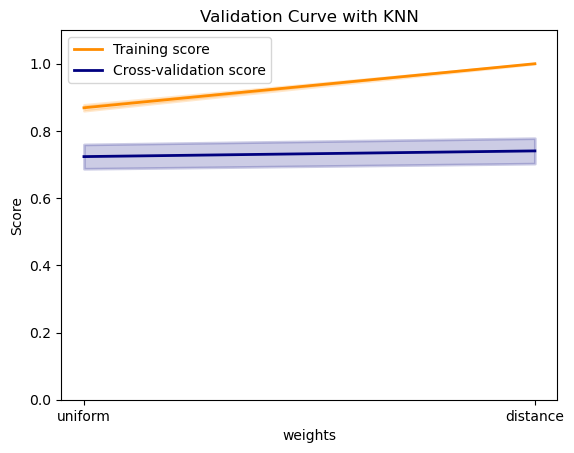

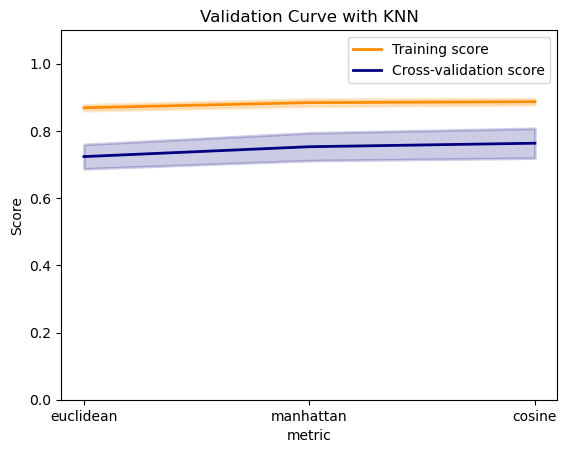

In [10]:
# | label: 1-e-2
for plot in plots:
    train_scores, test_scores = validation_curve(
        KNeighborsClassifier(),
        X_train_unscaled,
        y_train,
        param_name=plot,
        param_range=hyper_full_set[plot],
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
    )
    plot_validation(train_scores, test_scores, plot, hyper_full_set[plot])

Increasing `n_neighbors` initially leads to an improvement that plateaus after around 50 neighbors. Scaling the variables also boosts performance. The choice of the metric, on the other hand, does not seem to have much impact. Note that the default metric compared with the uniform distribution is the euclidian one.

Obviously, the interpretability of these plots is limited: we only see marginal effects of individual hyperparameters. The fact that they really interact with each other contributes substantially to the difficulty of the tuning problem. We can clearly see this in the plots for k, where we have two quite distinct patterns corresponding to different values of scale.

### f)

In [11]:
# | label: 1-f-1
# List hyperparameters that we want to tune, but with log-scaled n_neighbors
n_neighbors = list(np.linspace(np.log(1), np.log(100), 100))
n_neighbors = list(map(math.exp, n_neighbors))
n_neighbors = list(
    map(round, n_neighbors)
)  # now smaller numbers are much more likely to be chosen by RandomizedSearchCV

weights = ["uniform", "distance"]
metric = ["euclidean", "manhattan", "cosine"]
# Convert to dictionary
hyperparameters = [
    dict(n_neighbors=n_neighbors, weights=[weights[0]]),
    dict(n_neighbors=n_neighbors, weights=[weights[1]], metric=metric),
]

In [12]:
# | label: 1-f-2
# Create new KNN instance
knn = KNeighborsClassifier()
# Use RandomSearch
clf_auc = RandomizedSearchCV(
    estimator=knn,
    param_distributions=hyperparameters,
    scoring="roc_auc",  # use the AUC metric for finding the best hyperparameter set
    n_iter=200,
    cv=5,
    n_jobs=-1,
    random_state=123,
)

### g)

Performance on test data:

In [13]:
# | label: 1-g-1
# Fit the model
best_model_auc = clf_auc.fit(X_train, y_train)
# Print The value of best Hyperparameters
print("Best n_neighbors:", best_model_auc.best_estimator_.get_params()["n_neighbors"])
print("Best weights:", best_model_auc.best_estimator_.get_params()["weights"])
print("Best metric:", best_model_auc.best_estimator_.get_params()["metric"])

Best n_neighbors: 39
Best weights: distance
Best metric: manhattan


As can be observed, the log-transformation does not have a high effect on the tuning process.

In [14]:
# |label: 1-g-2
y_pred = best_model_auc.predict(X_test)
auc_score = roc_auc_score(y_test, y_pred)

print("AUC score:", auc_score)
print("Accuracy:", best_model_auc.score(X_test, y_test))

AUC score: 0.834873949579832
Accuracy: 0.8760504201680672
